# Setting up a non-equilibrium dynamic simulation on quantum hardware
___

This notebook executes the example outlined in Sec. 7.2.


## Overview
In this notebook, we will learn how to design a quantum circuit in Qiskit to simulate a quantum quench and run the circuit on the IBM's Quantum Computer and quantum simulator. [Qiskit](https://qiskit.org/) is a python library developed by IBM for designing quantum circuits and interfacing with their quantum computer over the cloud. You can get started right away by creating an [IBM Q Experience](https://quantum-computing.ibm.com/login) account.  The Hamiltonian of interest is a one-dimensional(1D) antiferromagnetic (AF) Heisenberg  model (equation 18 in the Review paper):

$H = J \sum_{i=1} \{\sigma_{i}^x \sigma_{i+1}^x + \sigma_{i}^y \sigma_{i+1}^y + g\sigma_{i}^z \sigma_{i+1}^z \}$

To perform a quantum quench, we initialize the qubits into the ground state of an inital Hamiltonian and then evolve the system under a final Hamiltonian. In this example, we set $J=1$ take the initial Hamiltonian to be the limit of $g \rightarrow \infty$. The ground state of this Hamilotian is the N\'eel state, given by $|\psi_0\rangle = |\uparrow \downarrow \uparrow ... \downarrow\rangle$.  Thus, the first part of our quantum circuit needs to initialize the qubits into this state, which simply requires apply the $X$-gate on alternating qubits.

Next, we need to evolve the system under the final Hamiltonian.  In this example, we perform three different quenches by setting $J=1$ and setting $g$ to three different values: g={0,0.2,4.0}.  In order to simulate the evolution of the qubits under this Hamitonian, we must apply the time-evolution operator $U(t)$ to the qubits, which for a time-independent Hamiltonian is given by:

$U(t) = e^{-iHt/\hbar}$

Since exponentiation of the Hamiltonian is difficult, we use the Trotter decomposition.  To perform the Trotter decomposition, the Hamiltonian must be divided into components that are each efficiently diagonalizable on their own:

$H = H_x + H_y + H_z $

Then, the time evolution operator can be approximated as:
$U(n \Delta t) = \prod_{j=0}^{n-1} e^{-iH_{x}\Delta t/\hbar}e^{-iH_{y}\Delta t/\hbar} e^{-iH_{z}\Delta t/\hbar}$

Finally, the observable of interest is the staggered magnetization, given by 

$m_s(t) = \frac{1}{N}\sum_i (-1)^i \langle\sigma_{i}^{z}(t)\rangle$

Fortunately, this only requires measuring the expectation of the Pauli-Z operator, which can be derived from an ensemble of measurements of the qubits in the computational basis, and thus requires no extra gates.  It only requires a small amount of post-processing from qubit measurements.

First we import necessary libraries and define our system parameters, and then we outline how to build up the quantum circuit and run it below.

In [1]:
#import necessary libraries
import numpy as np
import qiskit as qk
from qiskit.tools.monitor import job_monitor
from qiskit import Aer, IBMQ, execute
import matplotlib.pyplot as plt


#Simulation parameters
#define Heisenberg model parameters
N = 7 #number of spins/qubits
J = 1.0
g = 0.2 #we will vary this parameter

delta_t = 0.025 #time-step size
num_steps = 10 #number of time-steps, we start with a small number for speed of demonstration
shots = 1024 #number of shots for circuit execution

## Create initial state preparation circuit

In [2]:
#create the initial state preparation (ISP) circuit
ISP_circuit = qk.QuantumCircuit(N)
ISP_circuit.x(1)
ISP_circuit.x(3)
ISP_circuit.x(5)

#draw the circuit
ISP_circuit.draw()

q_0: ─────
     ┌───┐
q_1: ┤ X ├
     └───┘
q_2: ─────
     ┌───┐
q_3: ┤ X ├
     └───┘
q_4: ─────
     ┌───┐
q_5: ┤ X ├
     └───┘
q_6: ─────

## Create the time-evolution circuit

In [3]:
#create the circuit to execute the time-evolution operator for a given time-step

def evolution_circuit(num_time_steps, J, g, N):
    hbar = 0.658212    # eV*fs
    time_evol_circuit = qk.QuantumCircuit(N)
    #define rotation angles for gates in circuit
    psiX = 2.0*J*delta_t/hbar
    psiY = 2.0*J*delta_t/hbar
    psiZ = 2.0*J*g*delta_t/hbar

    for step in range(num_time_steps):
        #implement XX operator
        for q in range(0,N-1):
            time_evol_circuit.h(q)
            time_evol_circuit.h(q+1)
            time_evol_circuit.cx(q,q+1)
            time_evol_circuit.rz(psiX,q+1)
            time_evol_circuit.cx(q,q+1)
            time_evol_circuit.h(q)
            time_evol_circuit.h(q+1)
        #implement YY operator
        for q in range(0,N-1):
            time_evol_circuit.rx(-np.pi/2,q)
            time_evol_circuit.rx(-np.pi/2,q+1)
            time_evol_circuit.cx(q,q+1)
            time_evol_circuit.rz(psiY,q+1)
            time_evol_circuit.cx(q,q+1)
            time_evol_circuit.rx(np.pi/2,q)
            time_evol_circuit.rx(np.pi/2,q+1)
        #implement ZZ operator
        for q in range(0,N-1):
            time_evol_circuit.cx(q, q+1)
            time_evol_circuit.rz(psiZ, q+1)
            time_evol_circuit.cx(q, q+1)
    return time_evol_circuit

#draw circuit for time-step 1
circ = evolution_circuit(1,J,g,N)
circ.draw()

┌───┐                          ┌───┐┌──────────┐                          »
q_0: ┤ H ├──■────────────────────■──┤ H ├┤ RX(-π/2) ├──────────────────────────»
     ├───┤┌─┴─┐┌──────────────┐┌─┴─┐├───┤└──┬───┬───┘                          »
q_1: ┤ H ├┤ X ├┤ RZ(0.075963) ├┤ X ├┤ H ├───┤ H ├──────■────────────────────■──»
     ├───┤└───┘└──────────────┘└───┘└───┘   └───┘    ┌─┴─┐┌──────────────┐┌─┴─┐»
q_2: ┤ H ├───────────────────────────────────────────┤ X ├┤ RZ(0.075963) ├┤ X ├»
     ├───┤                                           └───┘└──────────────┘└───┘»
q_3: ┤ H ├─────────────────────────────────────────────────────────────────────»
     ├───┤                                                                     »
q_4: ┤ H ├─────────────────────────────────────────────────────────────────────»
     ├───┤                                                                     »
q_5: ┤ H ├─────────────────────────────────────────────────────────────────────»
     ├───┤                                                                     »
q_6: ┤ H ├─────────────────────────────────────────────────────────────────────»
     └───┘                                                                     »
«                                                ┌─────────┐                 »
«q_0: ───────────────────■────────────────────■──┤ RX(π/2) ├─────────────────»
«     ┌───┐┌──────────┐┌─┴─┐┌──────────────┐┌─┴─┐├─────────┤┌──────────┐     »
«q_1: ┤ H ├┤ RX(-π/2) ├┤ X ├┤ RZ(0.075963) ├┤ X ├┤ RX(π/2) ├┤ RX(-π/2) ├──■──»
«     ├───┤└──┬───┬───┘└───┘└──────────────┘└───┘└──┬───┬──┘├──────────┤┌─┴─┐»
«q_2: ┤ H ├───┤ H ├──────■────────────────────■─────┤ H ├───┤ RX(-π/2) ├┤ X ├»
«     └───┘   └───┘    ┌─┴─┐┌──────────────┐┌─┴─┐   ├───┤   └──┬───┬───┘└───┘»
«q_3: ─────────────────┤ X ├┤ RZ(0.075963) ├┤ X ├───┤ H ├──────┤ H ├──────■──»
«                      └───┘└──────────────┘└───┘   └───┘      └───┘    ┌─┴─┐»
«q_4: ──────────────────────────────────────────────────────────────────┤ X ├»
«                                                                       └───┘»
«q_5: ───────────────────────────────────────────────────────────────────────»
«                                                                            »
«q_6: ───────────────────────────────────────────────────────────────────────»
«                                                                            »
«                                                                 »
«q_0: ─────────────────────────────────────■──────────────────────»
«                          ┌─────────┐   ┌─┴─┐    ┌──────────────┐»
«q_1: ──────────────────■──┤ RX(π/2) ├───┤ X ├────┤ RZ(0.015193) ├»
«     ┌──────────────┐┌─┴─┐├─────────┤┌──┴───┴───┐└──────────────┘»
«q_2: ┤ RZ(0.075963) ├┤ X ├┤ RX(π/2) ├┤ RX(-π/2) ├───────■────────»
«     └──────────────┘└───┘└──┬───┬──┘├──────────┤     ┌─┴─┐      »
«q_3: ──────────────────■─────┤ H ├───┤ RX(-π/2) ├─────┤ X ├──────»
«     ┌──────────────┐┌─┴─┐   ├───┤   └──┬───┬───┘     └───┘      »
«q_4: ┤ RZ(0.075963) ├┤ X ├───┤ H ├──────┤ H ├───────────■────────»
«     └──────────────┘└───┘   └───┘      └───┘         ┌─┴─┐      »
«q_5: ─────────────────────────────────────────────────┤ X ├──────»
«                                                      └───┘      »
«q_6: ────────────────────────────────────────────────────────────»
«                                                                 »
«                                                                 »
«q_0: ───────■────────────────────────────────────────────────────»
«          ┌─┴─┐                                                  »
«q_1: ─────┤ X ├───────────────────────────■──────────────────────»
«          └───┘           ┌─────────┐   ┌─┴─┐    ┌──────────────┐»
«q_2: ──────────────────■──┤ RX(π/2) ├───┤ X ├────┤ RZ(0.015193) ├»
«     ┌──────────────┐┌─┴─┐├─────────┤┌──┴───┴───┐└──────────────┘»
«q_3: ┤ RZ(0.075963) ├┤ X ├┤ RX(π/2) ├┤ RX(-π/2) ├───────■────────»
«     └──────────────┘└───┘└──┬───┬──┘├──

## Compose the final circuits

For the dynamic simulation, we will need one circuit for every time-step.  Each circuit should have the same initial state preparation concatenated with the evolution circuit for the associated length of time simulated for the given time step.  Finally, measurement of each qubit should be added to each circuit.

In [4]:
#Create set of final circuits for quantum quench simulations
circuits = []
for i in range(0, num_steps+1):
    total_circ = qk.QuantumCircuit(N,N)
    total_circ.compose(ISP_circuit, inplace=True)
    total_circ.compose(evolution_circuit(i,J,g,N), inplace=True)
    total_circ.measure(range(N),range(N))
    circuits.append(total_circ)
    
#draw the circuit for the first time-step
circuits[1].draw()

┌───┐                               ┌───┐┌──────────┐                     »
q_0: ┤ H ├───────■────────────────────■──┤ H ├┤ RX(-π/2) ├─────────────────────»
     ├───┤┌───┐┌─┴─┐┌──────────────┐┌─┴─┐├───┤└──┬───┬───┘                     »
q_1: ┤ X ├┤ H ├┤ X ├┤ RZ(0.075963) ├┤ X ├┤ H ├───┤ H ├──────■──────────────────»
     ├───┤└───┘└───┘└──────────────┘└───┘└───┘   └───┘    ┌─┴─┐┌──────────────┐»
q_2: ┤ H ├────────────────────────────────────────────────┤ X ├┤ RZ(0.075963) ├»
     ├───┤┌───┐                                           └───┘└──────────────┘»
q_3: ┤ X ├┤ H ├────────────────────────────────────────────────────────────────»
     ├───┤└───┘                                                                »
q_4: ┤ H ├─────────────────────────────────────────────────────────────────────»
     ├───┤┌───┐                                                                »
q_5: ┤ X ├┤ H ├────────────────────────────────────────────────────────────────»
     ├───┤└───┘                                                                »
q_6: ┤ H ├─────────────────────────────────────────────────────────────────────»
     └───┘                                                                     »
c: 7/══════════════════════════════════════════════════════════════════════════»
                                                                               »
«                                                     ┌─────────┐            »
«q_0: ────────────────────────■────────────────────■──┤ RX(π/2) ├────────────»
«          ┌───┐┌──────────┐┌─┴─┐┌──────────────┐┌─┴─┐├─────────┤┌──────────┐»
«q_1: ──■──┤ H ├┤ RX(-π/2) ├┤ X ├┤ RZ(0.075963) ├┤ X ├┤ RX(π/2) ├┤ RX(-π/2) ├»
«     ┌─┴─┐├───┤└──┬───┬───┘└───┘└──────────────┘└───┘└──┬───┬──┘├──────────┤»
«q_2: ┤ X ├┤ H ├───┤ H ├──────■────────────────────■─────┤ H ├───┤ RX(-π/2) ├»
«     └───┘└───┘   └───┘    ┌─┴─┐┌──────────────┐┌─┴─┐   ├───┤   └──┬───┬───┘»
«q_3: ──────────────────────┤ X ├┤ RZ(0.075963) ├┤ X ├───┤ H ├──────┤ H ├────»
«                           └───┘└──────────────┘└───┘   └───┘      └───┘    »
«q_4: ───────────────────────────────────────────────────────────────────────»
«                                                                            »
«q_5: ───────────────────────────────────────────────────────────────────────»
«                                                                            »
«q_6: ───────────────────────────────────────────────────────────────────────»
«                                                                            »
«c: 7/═══════════════════════════════════════════════════════════════════════»
«                                                                            »
«                                                                      »
«q_0: ──────────────────────────────────────────■──────────────────────»
«                               ┌─────────┐   ┌─┴─┐    ┌──────────────┐»
«q_1: ──■────────────────────■──┤ RX(π/2) ├───┤ X ├────┤ RZ(0.015193) ├»
«     ┌─┴─┐┌──────────────┐┌─┴─┐├─────────┤┌──┴───┴───┐└──────────────┘»
«q_2: ┤ X ├┤ RZ(0.075963) ├┤ X ├┤ RX(π/2) ├┤ RX(-π/2) ├───────■────────»
«     └───┘└──────────────┘└───┘└──┬───┬──┘├──────────┤     ┌─┴─┐      »
«q_3: ──■────────────────────■─────┤ H ├───┤ RX(-π/2) ├─────┤ X ├──────»
«     ┌─┴─┐┌──────────────┐┌─┴─┐   ├───┤   └──┬───┬───┘     └───┘      »
«q_4: ┤ X ├┤ RZ(0.075963) ├┤ X ├───┤ H ├──────┤ H ├───────────■────────»
«     └───┘└──────────────┘└───┘   └───┘      └───┘         ┌─┴─┐      »
«q_5: ──────────────────────────────────────────────────────┤ X ├──────»
«                                                           └───┘      »
«q_6: ─────────────────────────────────────────────────────────────────»
«                                                                      »
«c: 7/═════════════════════════════════════════════════════════════════»
«                                                                      »
«                          ┌─┐              

## Run Circuits

In order to run the circuits on the quantum processor or simulator, you will need to connect with IBM's server. To do so, you will need you API_Token, which you can find by logging in to your IBM Q Experience account under "My Account".

The first time you run this notebook, you should run the save_account function with your token as the argument. This will since it will save your account in '~/.qiskit/qiskitrc', so all future times running this notebook you will only need to load your account with the load_account function. You can delete this file if you need to regenerate a token with delete_account.

In [5]:
#qk.IBMQ.save_account('here') ## only run once!
#qk.IBMQ.delete_accounts() ## only run if you need to use a new token
qk.IBMQ.load_account()

/opt/anaconda3/lib/python3.8/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

Next, we need to choose on backend on which to run our quantum circuits.
We can either run on a quantum simulator or a real quantum processor.  You can only run on a quantum processor your account has access to, so be sure to check!

In [6]:
#Show available backends
provider = qk.IBMQ.get_provider(group='open')
provider.backends()

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmqx2') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_16_melbourne') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_vigo') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_ourense') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_valencia') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_armonk') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_athens') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_santiago') from IBMQ(hub='ibm-q', group='open', project='main')>]

In [7]:
#To run on the quantum computer, assign a quantum computer of your choice as the backend 
#backend = provider.get_backend('ibmq_ourense')
#Or if you wish to run on the quantum simulator, select the QasmSimulator from the Aer provider
backend = Aer.get_backend('qasm_simulator')

Given a backend, we can now transpile our circuits so they may run on our chosen backend.

In [8]:
#Transpile the circuits
circs = qk.transpile(circuits, backend=backend, optimization_level=3)

In [9]:
#Run job according to backend, either a quantum processor OR the quantum simulator

########Uncomment this section to run on quantum processor#########
#quantum computer execution
#job = qk.execute(circ, backend=backend, shots=shots)
#job_monitor(job)
#results = job.result()  
####################################################################

#Line below executes simulation on quantum simulator execution
results = execute(circs, backend).result()

## Post-Processing Results


Finally, some post-processing is required to compute the staggered magnetization from the measurement results from the quantum backend.  A measured value of $0$ for a given qubit maps to a value of $+1$ for the expecatation value of the Pauli-Z operator, while a measured value of $1$ for a given qubit maps to a value of $-1$ for the expecatation value of the Pauli-Z operator.  Recall the staggered magnetization is computed from the expecatation values of the Pauli-Z operator for each qubit. 

In [10]:
#define function to compute staggered magnetization
def staggered_magnetization(result: dict, shots: int):
    """Compute staggered magnetization from results of execute function.
    Args:
    - result (dict): a dictionary with the counts for each qubit, see qk.result.result module
    - shots (int): number of trials
    Return:
    - staggered_mag (float)
    """
    sm_val = 0
    for spin_str, count in result.items():
        spin_int = [1 - 2 * float(s) for s in spin_str]
        for i in range(len(spin_int)):
            spin_int[i] = spin_int[i]*(-1)**i
        sm_val += (sum(spin_int) / len(spin_int)) * count
    average_sm = sm_val/shots
    return average_sm

In [11]:
#Post-processing results
avg_sm = []
for c in circs:
    result_dict = results.get_counts(c)
    avg_sm.append(staggered_magnetization(result_dict, shots))

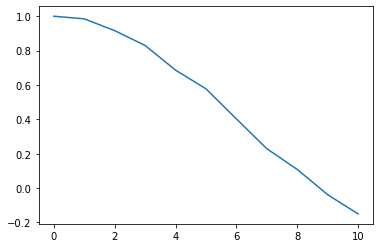

In [12]:
#Plot results
plt.plot(range(num_steps+1), avg_sm)
plt.show()

## Reproduce plot in Figure 6 in Review paper 

To reproduce the plot in Figure 6, we must run the simulation three separate times for the three different values of $g$: $g=0$, $g=0.2$, and $g=4.0$, and increase the number of time-steps to 100. 
<span style="color:red">**Note that circuit creation and transpilation make take some time as we are using 100 time-steps!**</span>

In [38]:
g=0
num_steps=100
#create and traspile circuits for g=0
circuits_g0 = []
for i in range(0, num_steps+1):
    total_circ = qk.QuantumCircuit(N,N)
    total_circ.compose(ISP_circuit, inplace=True)
    total_circ.compose(evolution_circuit(i,J,g,N), inplace=True)
    total_circ.measure(range(N),range(N))
    circuits_g0.append(total_circ)
print('Circuits created for g=0')
circs_g0 = qk.transpile(circuits_g0, backend=backend, optimization_level=3)
print('Circuits transpiled for g=0')

#create and traspile circuits for g=0.2
g=0.2
circuits_g02 = []
for i in range(0, num_steps+1):
    total_circ = qk.QuantumCircuit(N,N)
    total_circ.compose(ISP_circuit, inplace=True)
    total_circ.compose(evolution_circuit(i,J,g,N), inplace=True)
    total_circ.measure(range(N),range(N))
    circuits_g02.append(total_circ) 
print('Circuits created for g=0.2')
circs_g02 = qk.transpile(circuits_g02, backend=backend, optimization_level=3)
print('Circuits transpiled for g=0.2')
#create and traspile circuits for g=4.0
g=4.0
circuits_g4 = []
for i in range(0, num_steps+1):
    total_circ = qk.QuantumCircuit(N,N)
    total_circ.compose(ISP_circuit, inplace=True)
    total_circ.compose(evolution_circuit(i,J,g,N), inplace=True)
    total_circ.measure(range(N),range(N))
    circuits_g4.append(total_circ)
print('Circuits created for g=4')
circs_g4 = qk.transpile(circuits_g4, backend=backend, optimization_level=3)
print('Circuits transpiled for g=4')

Circuits created for g=0
Circuits transpiled for g=0
Circuits created for g=0.2
Circuits transpiled for g=0.2
Circuits created for g=4
Circuits transpiled for g=4


In [39]:
#Execute all simulations
results0 = execute(circs_g0, backend).result()
results02 = execute(circs_g02, backend).result()
results4 = execute(circs_g4, backend).result()

In [40]:
#Post-process all results
avg_sm0 = []
for c in circs_g0:
    result_dict = results0.get_counts(c)
    avg_sm0.append(staggered_magnetization(result_dict, shots))

avg_sm02 = []
for c in circs_g02:
    result_dict = results02.get_counts(c)
    avg_sm02.append(staggered_magnetization(result_dict, shots))
    
avg_sm4 = []
for c in circs_g4:
    result_dict = results4.get_counts(c)
    avg_sm4.append(staggered_magnetization(result_dict, shots))

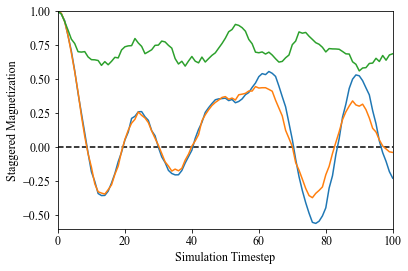

In [41]:
#Plot the results
plt.figure(figsize=(6,4))
plt.plot(avg_sm0, label="$g=0$")
plt.plot(avg_sm02, label="$g=0.2$")
plt.plot(avg_sm4, label="$g=4.0$")
plt.hlines(0, 0, 150, linestyles='dashed')
plt.ylim(-0.6,1.0)
plt.xlim(0,100)
#plt.legend()
plt.xlabel("Simulation Timestep", fontsize=12, fontname="Times New Roman")
plt.yticks([-0.5, -0.25, 0.0, 0.25, 0.5, 0.75, 1.0], fontsize=12, fontname="Times New Roman")
plt.xticks(fontsize=12, fontname="Times New Roman")
plt.ylabel("Staggered Magnetization", fontsize=12, fontname="Times New Roman")
plt.show()
#Use line below to save figuge as a PNG file
#plt.savefig("staggered_mag.png")